In [40]:
# L 4-30-25

[INFO] Generating spectrograms from: ../data/Songs/
[INFO] Generating VGGish embeddings for song inference set...


Processing Rock: 100%|██████████| 100/100 [00:00<00:00, 100150.53it/s]



Successfully processed: 0
Failed to process: 0
Saved metadata to ../reports/step_final_classify/vggish_metadata_songs.csv

RF Classification Report

               precision    recall  f1-score   support

   Electronic       0.20      0.47      0.28        17
 Experimental       0.20      0.21      0.21        14
         Folk       0.23      0.41      0.29        17
      Hip-Hop       0.29      0.33      0.31        15
 Instrumental       0.29      0.47      0.36        15
International       0.27      0.25      0.26        16
          Pop       0.08      0.17      0.11        18
         Rock       0.97      0.30      0.46       100

     accuracy                           0.32       212
    macro avg       0.32      0.33      0.28       212
 weighted avg       0.57      0.32      0.35       212



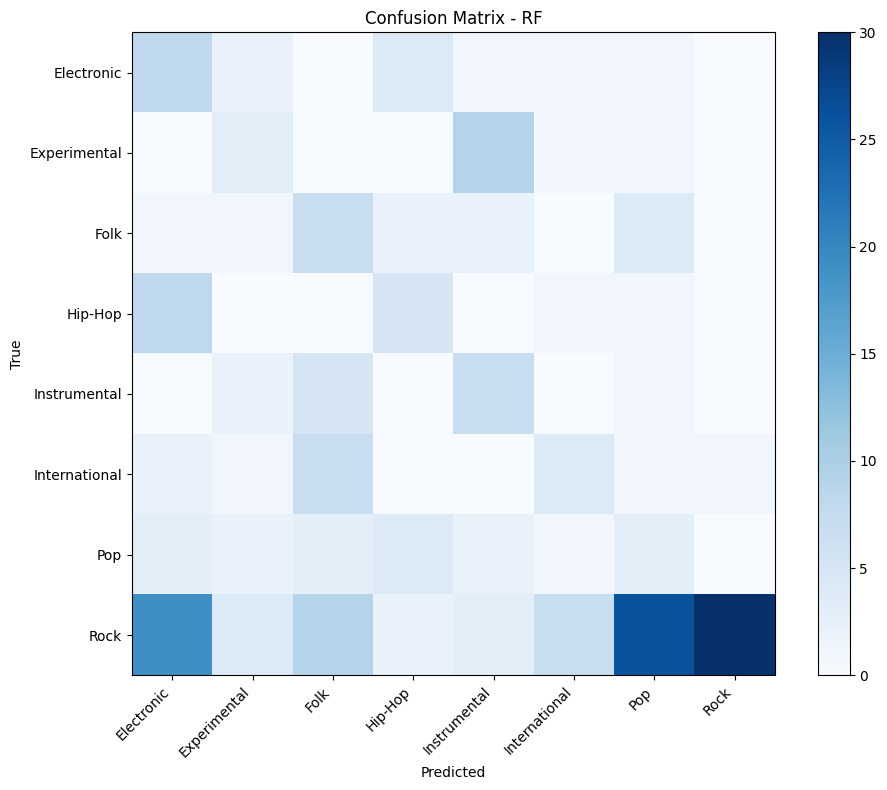

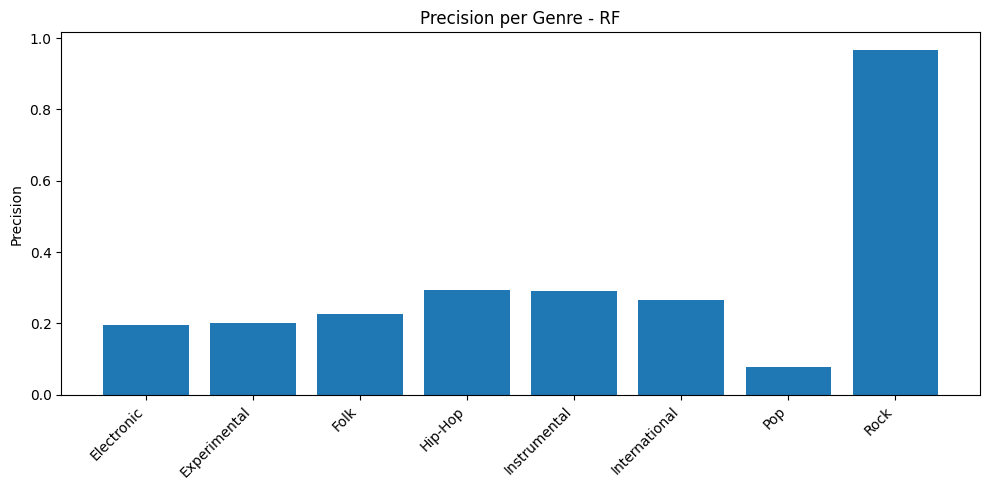

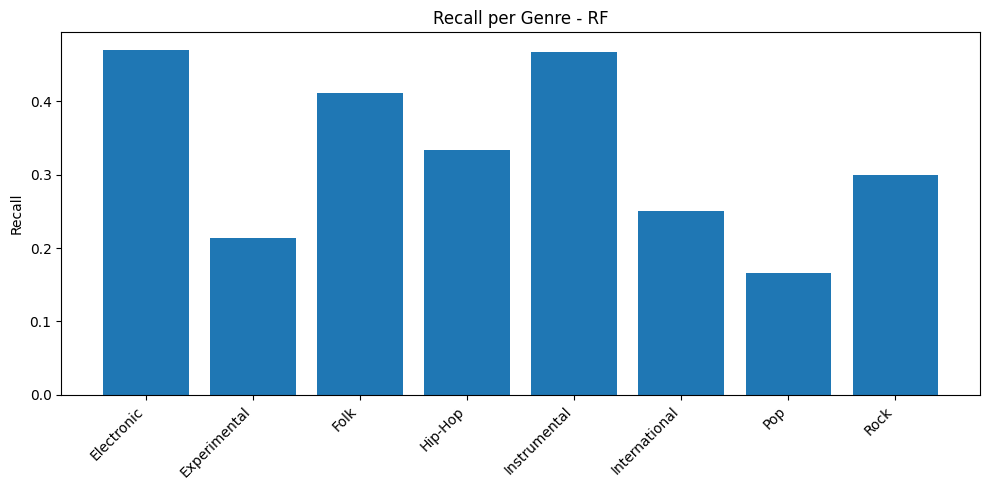

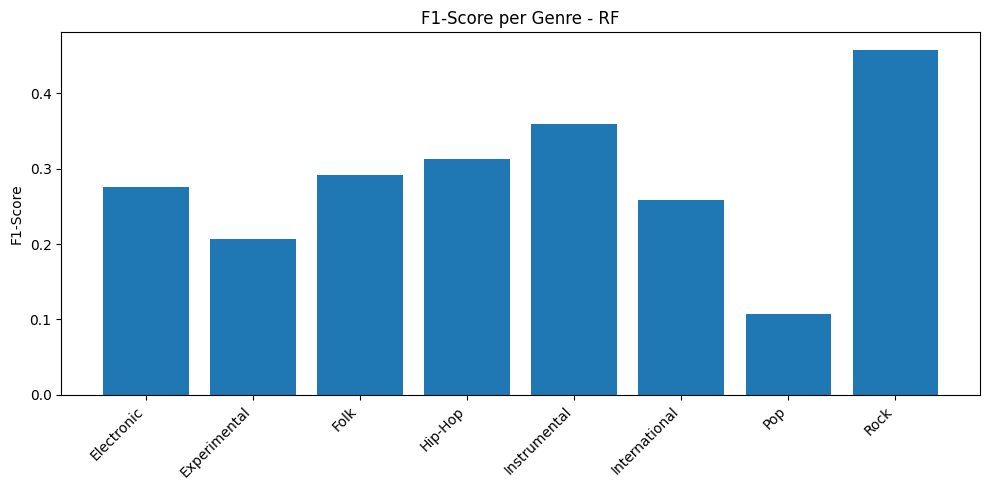


CNN Classification Report

               precision    recall  f1-score   support

   Electronic       0.14      0.06      0.08        17
 Experimental       0.27      0.21      0.24        14
         Folk       0.16      0.41      0.23        17
      Hip-Hop       0.20      0.60      0.30        15
 Instrumental       0.31      0.73      0.44        15
International       0.38      0.56      0.45        16
          Pop       0.09      0.17      0.11        18
         Rock       0.91      0.10      0.18       100

     accuracy                           0.25       212
    macro avg       0.31      0.36      0.25       212
 weighted avg       0.54      0.25      0.22       212



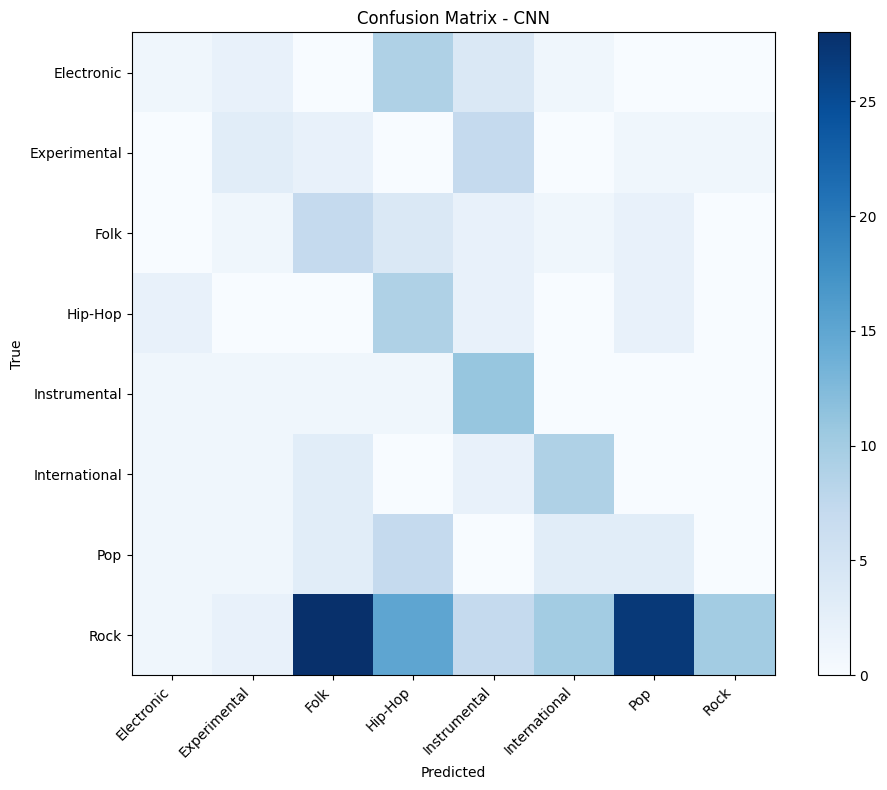

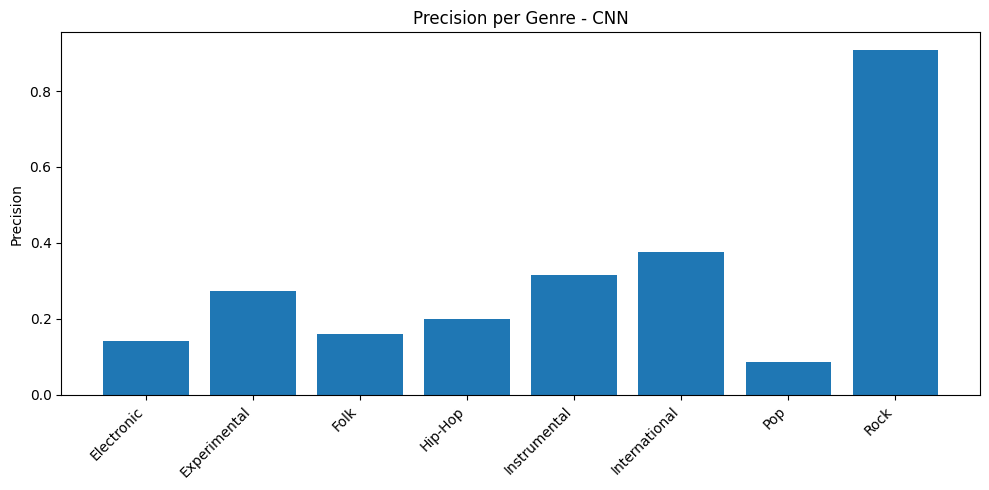

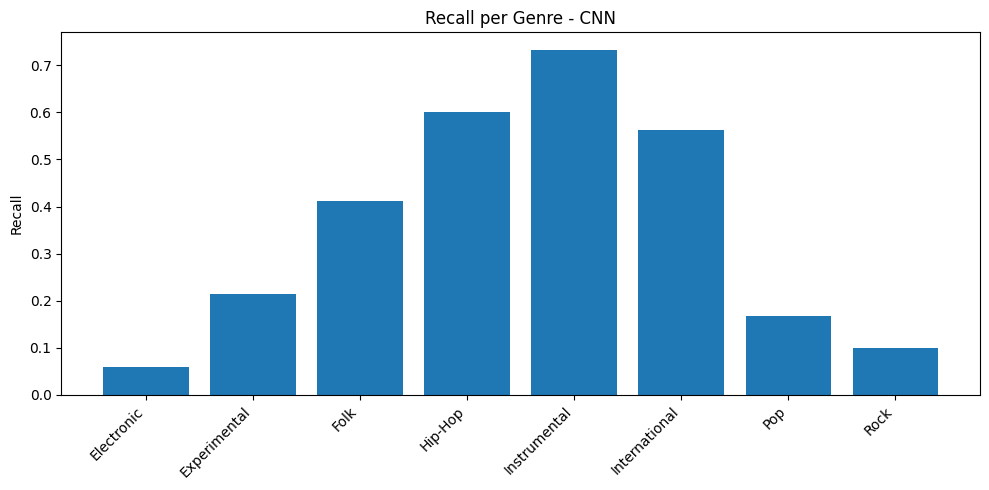

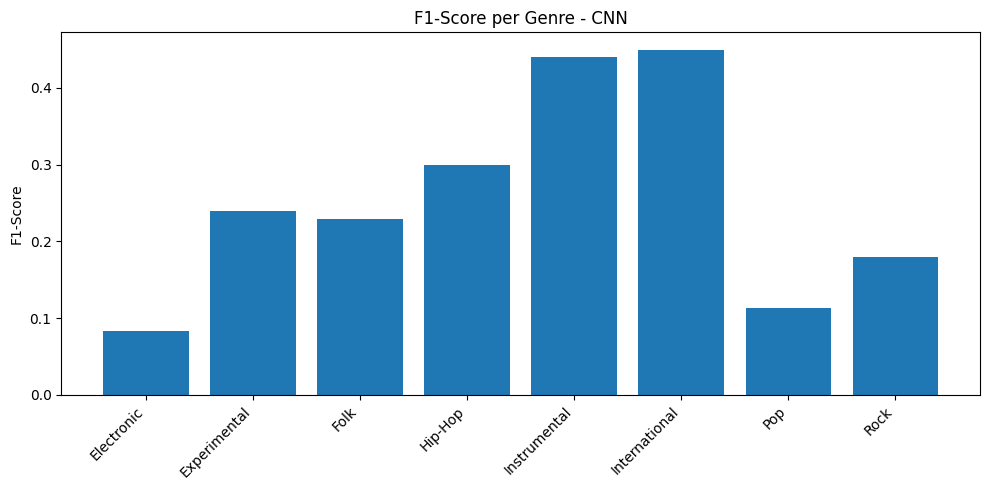


VGGISH Classification Report

               precision    recall  f1-score   support

   Electronic       0.54      0.82      0.65        17
 Experimental       0.50      0.29      0.36        14
         Folk       0.52      0.76      0.62        17
      Hip-Hop       0.75      0.80      0.77        15
 Instrumental       0.50      0.47      0.48        15
International       0.57      0.81      0.67        16
          Pop       0.09      0.33      0.15        18
         Rock       0.94      0.34      0.50       100

     accuracy                           0.49       212
    macro avg       0.55      0.58      0.53       212
 weighted avg       0.70      0.49      0.51       212



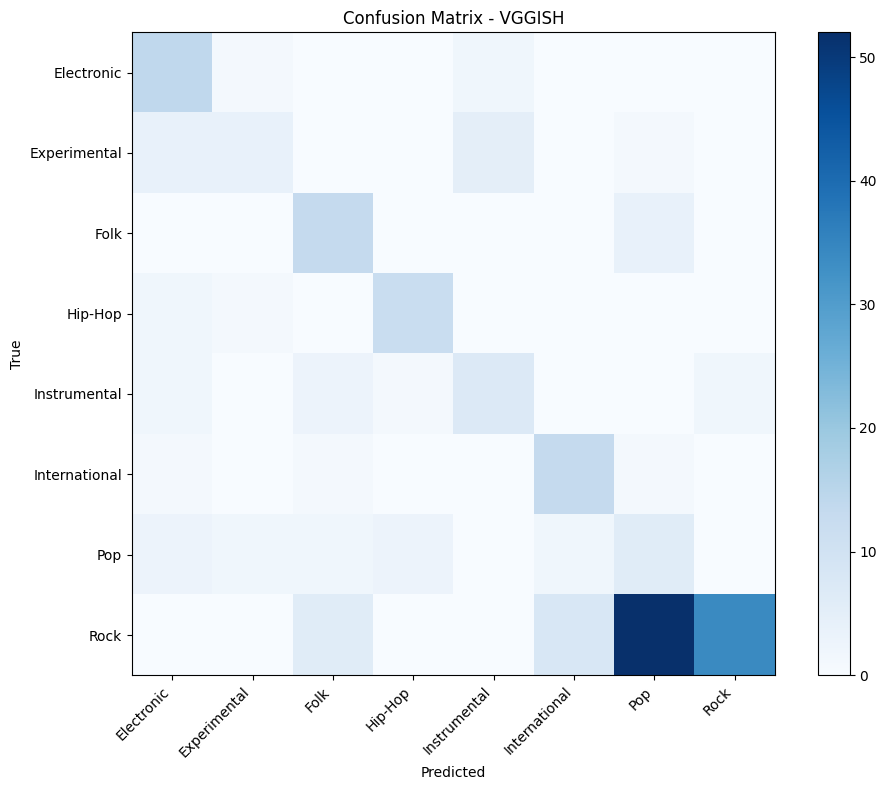

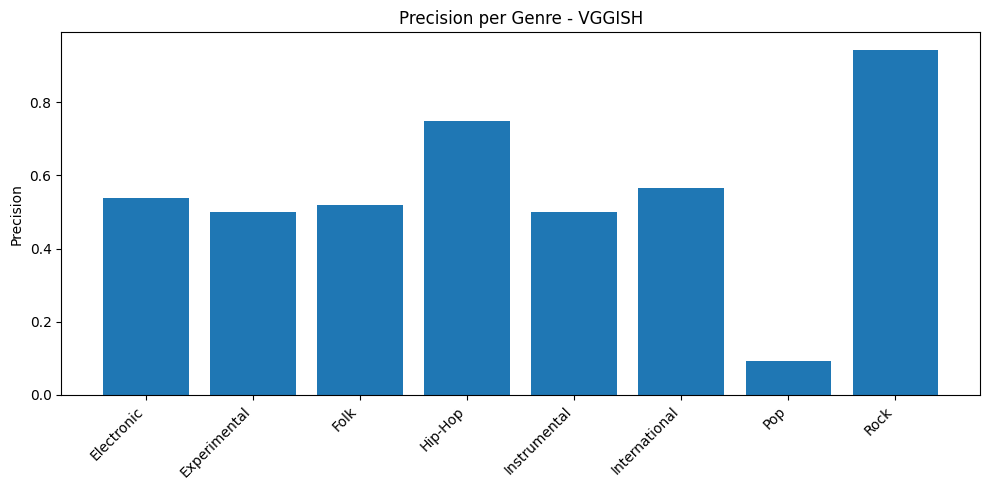

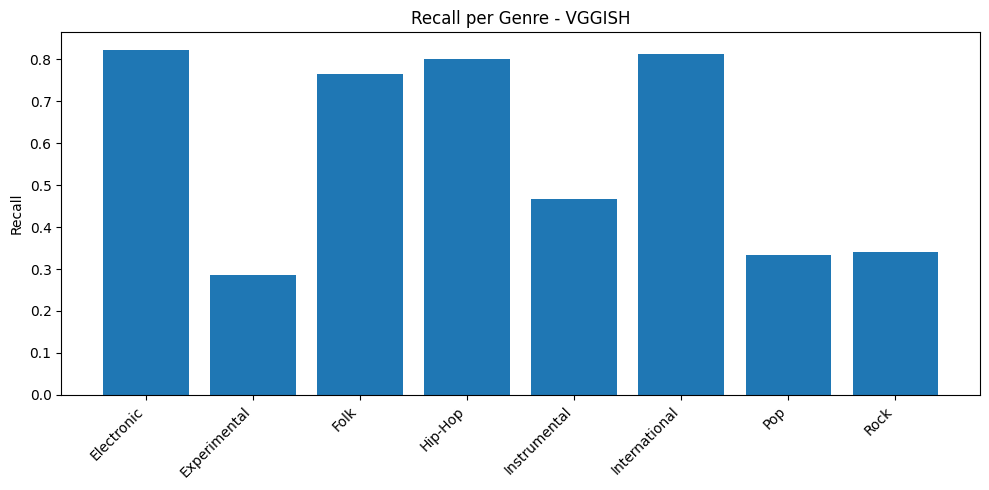

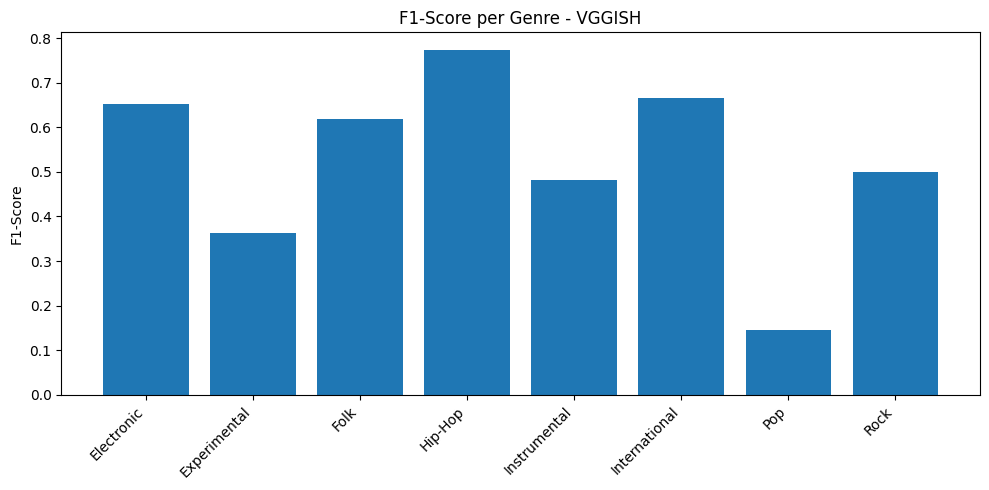

In [ ]:
# L 4-30-25
# notebooks/step_final_classify.ipynb

# Modular inference pipeline setup for song classification using RF + CNN

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import joblib
import runpy

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import step_3_1_Gen_Spectro
import step_3_2_CNN_Spectro
import step_4_1_Gen_vggish_embed
import step_4_2_Vggish_Class
import importlib

sys.path.append(os.getcwd())  # ensure working directory is included
importlib.reload(step_3_1_Gen_Spectro)  # force reload in case of cache
importlib.reload(step_3_2_CNN_Spectro)  # force reload in case of cache
importlib.reload(step_4_1_Gen_vggish_embed)  # force reload in case of cache
importlib.reload(step_4_2_Vggish_Class)  # force reload in case of cache

RUN_MODE = "songs"

# Paths
SONG_DIR = "../data/Songs/"

RF_OUTPUT_DIR = "../reports/step_final_classify/RF/"
CNN_OUTPUT_DIR = "../reports/step_final_classify/CNN/"
CNN_BUNDLE_PATH = "../models/cnn_inference_bundle.pth"
CNN_MODEL_PATH = "../models/cnn_model.pth"
SPECTRO_DIR = "../reports/step_final_classify/spectrograms/"

VGGISH_SONG_OUTPUT_DIR = "../reports/step_final_classify/vggish_embeddings/"
VGGISH_SONG_METADATA = "../reports/step_final_classify/vggish_metadata_songs.csv"
VGGISH_RF_MODEL = "../models/vggish_rf_model.pkl"
VGGISH_CLASS_NAMES = "../reports/step_4_2_vggish_class/vggish_rf_class_names.npy"
VGGISH_OUTPUT_DIR = "../reports/step_final_classify/VGGish/"

COMBINED_OUTPUT_PATH = "../reports/step_final_classify/all_model_predictions.csv"

# Ensure directories exist
os.makedirs(RF_OUTPUT_DIR, exist_ok=True)
os.makedirs(CNN_OUTPUT_DIR, exist_ok=True)
os.makedirs(SPECTRO_DIR, exist_ok=True)
os.makedirs(VGGISH_SONG_OUTPUT_DIR, exist_ok=True)
os.makedirs(VGGISH_OUTPUT_DIR, exist_ok=True)

# Output controls

SHOW_PLOTS = True
%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)


# Step 1: Generate spectrograms for new songs
DEFAULT_TRAIN_SPECTRO_DIR = "../spectrograms/"
if not os.path.exists(DEFAULT_TRAIN_SPECTRO_DIR) or len(os.listdir(DEFAULT_TRAIN_SPECTRO_DIR)) == 0:
    print("[INFO] Training spectrograms missing — generating using default config.")
    step_3_1_Gen_Spectro.generate_all()  # Calls step_3_1_Gen_Spectro.generate_all() with training paths
step_3_1_Gen_Spectro.generate_spectrograms_from_folder(
    song_dir=SONG_DIR,
    output_dir=SPECTRO_DIR,
    img_size=128
)

# Step 2: Run CNN model to regenerate predictions
if not (os.path.exists(CNN_BUNDLE_PATH) and os.path.exists(CNN_MODEL_PATH)):
    print("[INFO] CNN models not found. Training from FMA spectrograms...")
    step_3_2_CNN_Spectro.run()
cnn_df = step_3_2_CNN_Spectro.cnn_predict_folder(
    bundle_path=CNN_BUNDLE_PATH,
    image_dir=SPECTRO_DIR
)
cnn_df.to_csv(os.path.join(CNN_OUTPUT_DIR,
              "cnn_song_predictions.csv"), index=False)


# Step 3: Load Random Forest model
rf_model = joblib.load("../models/rf_model.pkl")

# Step 4: Helper for MFCC extraction


def extract_mfcc(path):
    y, sr = librosa.load(path, sr=None, duration=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    return np.concatenate([np.mean(mfcc, axis=1), np.std(mfcc, axis=1)])


# Step 5: Load CNN predictions from 3.2 output
cnn_df = pd.read_csv(os.path.join(CNN_OUTPUT_DIR, "cnn_song_predictions.csv"))

# Vggish

# print("There may be some errors, this is expected")
# step_4_1_Gen_vggish_embed.generate_vggish_embeddings()

print("[INFO] Generating VGGish embeddings for song inference set...")
step_4_1_Gen_vggish_embed.generate_vggish_embeddings(
    mp3_root=SONG_DIR,
    output_dir=VGGISH_SONG_OUTPUT_DIR,
    metadata_path=VGGISH_SONG_METADATA
)

# step_4_2_Vggish_Class.evaluate_on_new_embeddings(
#     model_path=VGGISH_RF_MODEL,
#     embedding_dir=VGGISH_SONG_OUTPUT_DIR,
#     metadata_file=VGGISH_SONG_METADATA,
#     report_dir=VGGISH_RF_SONG_REPORT_DIR
# )

vggish_df = step_4_2_Vggish_Class.predict_vggish_for_files(
    model_path=VGGISH_RF_MODEL,
    embedding_dir=VGGISH_SONG_OUTPUT_DIR,
    metadata_file=VGGISH_SONG_METADATA,
    class_names_path="../reports/step_4_2_vggish_class/vggish_rf_class_names.npy"
)


# Step 6: Inference loop
results = []
for genre_dir in os.listdir(SONG_DIR):
    genre_path = os.path.join(SONG_DIR, genre_dir)
    if not os.path.isdir(genre_path):
        continue

    for fname in os.listdir(genre_path):
        if not fname.endswith(".mp3"):
            continue

        base = os.path.splitext(fname)[0]
        fpath = os.path.join(genre_path, fname)
        spectro_path = os.path.join(SPECTRO_DIR, genre_dir, f"{base}.png")
        png_filename = f"{base}.png"

        try:
            mfcc_vector = extract_mfcc(fpath).reshape(1, -1)
            rf_pred = rf_model.predict(mfcc_vector)[0]
            cnn_pred = cnn_df.loc[cnn_df['file'] == png_filename, 'CNN'].values[0] \
                if png_filename in cnn_df['file'].values else "N/A"
            vggish_pred = vggish_df.loc[vggish_df['file'] == fname, 'VGGISH'].values[0] \
                if fname in vggish_df['file'].values else "N/A"

            results.append({
                "file": fname,
                "true_genre": genre_dir,
                "RF": rf_pred,
                "CNN": cnn_pred,
                "VGGISH": vggish_pred,
                "spectrogram_path": spectro_path
            })
        except Exception as e:
            print(f"Error processing {fname}: {e}")


# Step 7: Save combined predictions
df = pd.DataFrame(results)
df.to_csv(COMBINED_OUTPUT_PATH, index=False)

# Step 8: Evaluation (RF and CNN)
for model in ["RF", "CNN", "VGGISH"]:
    if model not in df.columns:
        continue

    if model == "RF":
        output_dir = RF_OUTPUT_DIR
    elif model == "CNN":
        output_dir = CNN_OUTPUT_DIR
    elif model == "VGGISH":
        output_dir = VGGISH_OUTPUT_DIR
    else:
        output_dir = RF_OUTPUT_DIR
            
    y_true = df["true_genre"]
    y_pred = df[model]
    labels_sorted = sorted(set(y_true) | set(y_pred))

    report = classification_report(
        y_true, y_pred, labels=labels_sorted, zero_division=0)
    with open(os.path.join(output_dir, f"{model.lower()}_classification_report.txt"), "w") as f:
        f.write(report)
        
    print(f"\n{model} Classification Report\n")
    print(report)

    cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title(f"Confusion Matrix - {model}")
    plt.colorbar()
    plt.xticks(np.arange(len(labels_sorted)),
               labels_sorted, rotation=45, ha='right')
    plt.yticks(np.arange(len(labels_sorted)), labels_sorted)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f"{model.lower()}_confusion_matrix.png"))
    if (SHOW_PLOTS == True):
        plt.show()
    plt.close()

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels_sorted, zero_division=0)
    metrics = {"Precision": precision, "Recall": recall, "F1-Score": f1}

    for metric_name, values in metrics.items():
        plt.figure(figsize=(10, 5))
        plt.bar(labels_sorted, values)
        plt.title(f"{metric_name} per Genre - {model}")
        plt.ylabel(metric_name)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        fname = f"{model.lower()}_{metric_name.lower().replace('-', '_')}_bar.png"
        
        plt.savefig(os.path.join(output_dir, fname))
        if(SHOW_PLOTS==True):
            plt.show()

        plt.close()
        